In [1]:
import sys
import os
sys.path.append('/Users/evatakou/noise_est')
import numpy as np
from matplotlib import pyplot as plt
import matplotlib



from sims.repetition_code_bare_ancilla.repetition_code_bare_ancilla_circuit  import *
from sims.repetition_code_bare_ancilla.construct_dem  import *
from sims.repetition_code_bare_ancilla.estimation_funcs_rep_code  import *
from utilities.utils_for_decoding import decode_both_dems_same_data



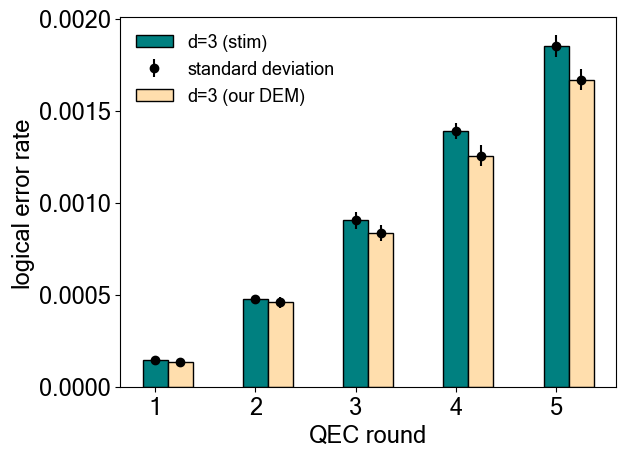

In [6]:
#W/ PARALLEL PROCESSING

fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"   

def plot_fid_vs_QEC_rds(L, num_shots, p_depol_after, after_CNOT_depol_type, iterMax, n_jobs=-1):
    from joblib import Parallel, delayed
    
    barWidth   = 0.25
    QEC_rounds = [1,2,3,4,5] #Up to 7 rds for d=5, Up to 5 rds for d=3, up to 9 rds for d=7
    Reset = True

    num_ancilla = L - 1
    p_data = 0
    p_anc = 0

    errors_per_rd_stim = []
    errors_per_rd_my_DEM = []
    all_std_stim = []
    all_std_my_DEM = []

    def process_iteration(rd):
        mean_stims_LE = []
        mean_my_LE = []

        for _ in range(iterMax):
            circuit          = repetition_code_circuit(L, rd, p_data, p_anc, Reset, p_depol_after, after_CNOT_depol_type)
            stims_DEM        = circuit.detector_error_model(flatten_loops=True)
            space_edge_names = space_bulk_edge_names(rd, num_ancilla)

            defects_matrix             = get_defects(num_shots, circuit, L, rd)
            pij_time, pij_bd, pij_bulk = extract_error_probs(defects_matrix)
            my_DEM                     = construct_estimated_DEM(pij_time, pij_bd, pij_bulk, space_edge_names, stims_DEM)
            my_LE, stims_LE            = decode_both_dems_same_data(my_DEM, circuit, num_shots)

            mean_stims_LE.append(stims_LE / num_shots)
            mean_my_LE.append(my_LE / num_shots)

        return (
            np.mean(mean_stims_LE),
            np.mean(mean_my_LE),
            np.std(mean_stims_LE),
            np.std(mean_my_LE),
            my_DEM,
            stims_DEM,
            pij_time,
            pij_bd,
            pij_bulk,
            circuit
        )

    results = Parallel(n_jobs=n_jobs)(delayed(process_iteration)(rd) for rd in QEC_rounds)

    for result in results:
        mean_stim, mean_my, std_stim, std_my, my_DEM, stims_DEM, pij_time, pij_bd, pij_bulk, circuit = result
        errors_per_rd_stim.append(mean_stim)
        errors_per_rd_my_DEM.append(mean_my)
        all_std_stim.append(std_stim)
        all_std_my_DEM.append(std_my)

    plt.bar(QEC_rounds, errors_per_rd_stim, width=barWidth, edgecolor='k', facecolor='teal')
    plt.errorbar(QEC_rounds, errors_per_rd_stim, all_std_stim, color="k", fmt="o")

    QEC_rounds_new = [x + barWidth for x in QEC_rounds]

    plt.bar(QEC_rounds_new, errors_per_rd_my_DEM, width=barWidth, edgecolor='k', facecolor='navajowhite')
    plt.errorbar(QEC_rounds_new, errors_per_rd_my_DEM, all_std_my_DEM, color="k", fmt="o")

    plt.legend([f'd={L} (stim)', 'standard deviation', f'd={L} (our DEM)'], 
               frameon=False, shadow=True, fontsize=13)
    plt.xticks(ticks=QEC_rounds, labels=["1", "2", "3", "4", "5"])
    plt.xlabel('QEC round')
    plt.ylabel('logical error rate')
    
    
    #Uncomment to save the figure
    # fig.savefig("d_3_LER_vs_QEC_rds_repeat_25.pdf",bbox_inches='tight')

    return my_DEM, stims_DEM, pij_time, pij_bd, pij_bulk, circuit


iterMax                                           = 25         
num_shots                                         = 5*10**5
L                                                 = 3
p_depol_after                                     = 0.01
after_CNOT_depol_type                             = "DEPOLARIZE2"
my_DEM,stims_DEM,pij_time,pij_bd,pij_bulk,circuit = plot_fid_vs_QEC_rds(L,num_shots,p_depol_after,after_CNOT_depol_type,iterMax)
